In [1]:
import torch
import skripsi_program
from skripsi_program import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    LSSVR,
    StandardScaler,
    reduce_coeff,
    zero_coeff,
    # rmse,
    # mse,
    # r2_score,
    # r2_expected_score,
)
import numpy as np
from torchmetrics.functional import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    relative_squared_error,
    symmetric_mean_absolute_percentage_error
)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
generator = torch.Generator().manual_seed(42)
modes = [200]
prod_modes = int(np.prod(modes))
num_samples = 201
k = FourierBasis.waveNumber(prod_modes)
u_coeff_clean = FourierBasis.generateCoeff(num_samples, prod_modes, generator=generator, random_func=torch.rand)
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * k.T / prod_modes
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * k.T / prod_modes # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape

torch.Size([201, 200])

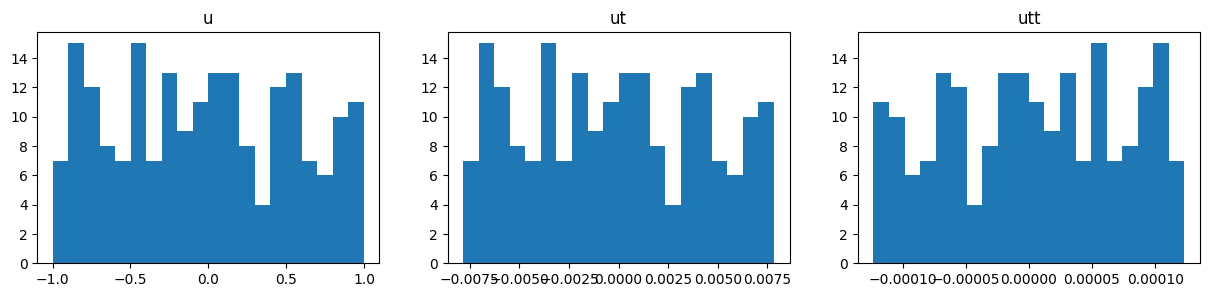

In [4]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

torch.Size([201, 900])

tensor(0.4929)

tensor(0.1680)

tensor(15.4930)

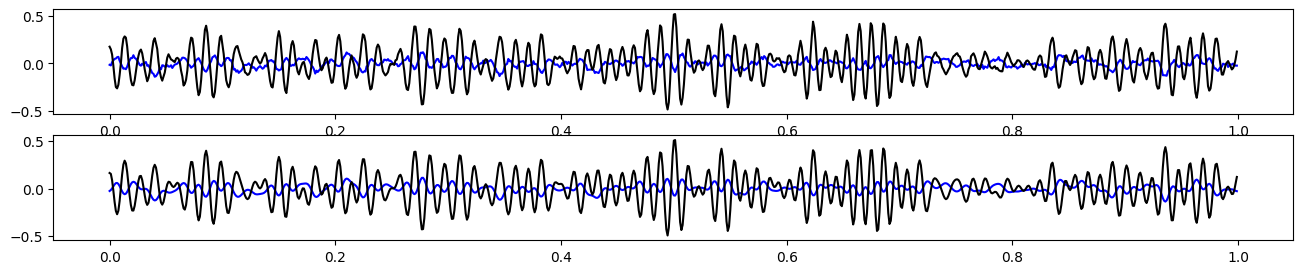

In [5]:
sample_freq = 900.0
sample_step = 1.0 / sample_freq
periods = [1.0] * len(modes)
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
points_tt = torch.concat([t.flatten().unsqueeze(-1) for t in tt], 1)
u_basis = FourierBasis(u_coeff_clean, periods)
ut_basis = FourierBasis(ut_coeff_clean, periods)
utt_basis = FourierBasis(utt_coeff_clean, periods)
u_clean = u_basis(points_tt).real
ut_clean = ut_basis(points_tt).real
utt_clean = utt_basis(points_tt).real
u = u_clean + torch.randn_like(u_clean) * 0.01
ut = ut_clean + torch.randn_like(ut_clean) * 0.01
utt = utt_clean + torch.randn_like(utt_clean) * 0.01
u_coeff = reduce_coeff(FourierBasis.transform(u), modes)
ut_coeff = reduce_coeff(FourierBasis.transform(ut), modes)
utt_coeff = reduce_coeff(FourierBasis.transform(utt), modes)
u_shape = u.shape


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = to_real_coeff(u_coeff), to_real_coeff(u_coeff_clean)
    l2_error = r2_score(u_real, u_clean_real)
    MSE = mean_squared_error(u_real, u_clean_real)
    display(u_shape)
    display(l2_error)
    display(MSE)
    display(20 * u_clean_real.max().log10() - 10 * MSE.pow(2).log10())


signal_stats()

plt.figure(figsize=(16, 3))
plt.subplot(211)
plt.plot(t, u[2].real, color="b")
plt.plot(t, utt[2].real, color="k")
plt.subplot(212)
plt.plot(t, u_clean[2].real, color="b")
plt.plot(t, utt_clean[2].real, color="k")
plt.show()

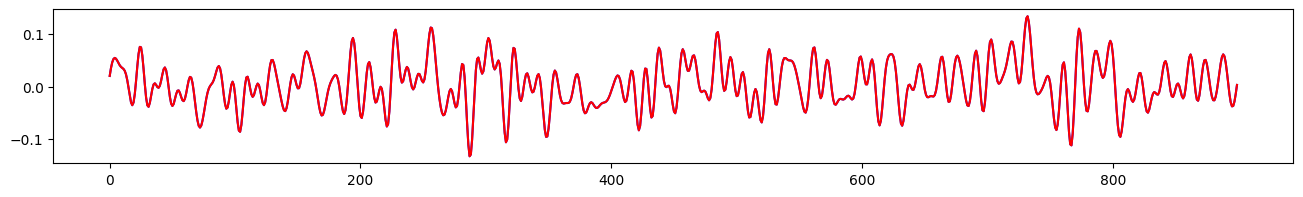

In [6]:

u_coeff_zeroed = zero_coeff(FourierBasis.transform(u), modes)
utt_coeff_zeroed = zero_coeff(FourierBasis.transform(utt), modes)
plt.figure(figsize=(16,2))
# plt.plot(u_clean.real[0], color="black")
plt.plot(FourierBasis(u_coeff,periods)(points_tt).real[0], color="blue")
plt.plot(FourierBasis(u_coeff_zeroed)(points_tt).real[0], color="red")
plt.show()

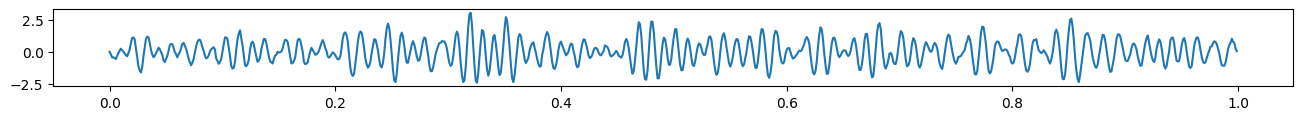

In [7]:
from torch.utils.data import TensorDataset, random_split

input_data = (utt, utt_coeff)
output_data = (u, u_coeff)
# data = (utt, utt_coeff, u, u_coeff_zeroed)
# (utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = data
scaler = StandardScaler().fit(input_data)
input_data_scaled = scaler.transform(input_data)
dataset = TensorDataset(*input_data_scaled, *output_data)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.figure(figsize=(16, 1))
plt.plot(points_tt[:], dataset[0][0])
plt.show()

In [63]:
low_freq.shape, high_freq.shape

(torch.Size([76]), torch.Size([124]))

In [86]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_input_train = f_train
f_input_train = to_real_coeff(f_coeff_train)
# low_freq = torch.concat(
#     (torch.tensor(range(13)), torch.tensor(range(187, u_coeff_train.shape[1])))
# )
# high_freq = torch.tensor(range(13, 187))
low_freq = torch.concat(
    (torch.tensor(range(38)), torch.tensor(range(162, u_coeff_train.shape[1])))
)
high_freq = torch.tensor(range(38, 162))
f_input_train_hf = to_real_coeff(f_coeff_train[:, high_freq])
f_input_train_lf = to_real_coeff(f_coeff_train[:, low_freq])
u_coeff_train_hf = u_coeff_train[:, high_freq]
u_coeff_train_lf = u_coeff_train[:, low_freq]

# model = SpectralSVR(FourierBasis(periods=periods), C=41.6207,sigma=4.0776, kernel="linear")
model_hf = SpectralSVR(
    FourierBasis(periods=periods),
    C=0.15,
    # C=200.10,
    # sigma=1.0,
    # sigma=f_input_train.var(0).median().multiply(f_input_train.shape[1]).pow(0.5),
    # sigma=f_input_train.var(0).sum().pow(0.5) * 1.0,
    # sigma=70.0,
    kernel="linear",
    # kernel="rbf",
    # verbose="LSSVR",
)
model_lf = SpectralSVR(
    FourierBasis(periods=periods),
    C=15.5,
    # C=200.10,
    # sigma=1.0,
    # sigma=f_input_train_lf.var(0).median().multiply(f_input_train_lf.shape[1]).pow(0.5),
    sigma=f_input_train_lf.var(0).sum().pow(0.5),
    # sigma=70.0,
    # kernel="linear",
    # kernel="rbf",
    # verbose="LSSVR",
)
# model.train(f_input_train, u_coeff_train * 900/200, list(u_coeff_zeroed.shape[1:]))
# model.train(f_input_train, u_coeff_train, modes)
model_hf.train(f_input_train_hf, u_coeff_train_hf, [u_coeff_train_hf.shape[1]])
model_lf.train(f_input_train_lf, u_coeff_train_lf, [u_coeff_train_lf.shape[1]])
# lssvr.fit(points_sampled, u_sampled.T)

In [87]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_input_test = f_test
f_input_test = to_real_coeff(f_coeff_test)
f_input_test_hf = to_real_coeff(f_coeff_test[:,high_freq])
f_input_test_lf = to_real_coeff(f_coeff_test[:,low_freq])

# u_pred = model_hf.forward(f_input_test, points_tt)
u_coeff_pred_hf = to_complex_coeff(model_hf.svr.predict(f_input_test_hf))
# u_pred= model_lf.forward(f_input_test, points_tt)
u_coeff_pred_lf = to_complex_coeff(model_lf.svr.predict(f_input_test_lf))
# u_coeff_pred = u_coeff_pred * u_coeff_test.std() / u_coeff_pred.std()
# u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_coeff_pred = torch.empty_like(u_coeff_test)
u_coeff_pred[:, low_freq] = u_coeff_pred_lf
u_coeff_pred[:, high_freq] = u_coeff_pred_hf
u_pred_basis = FourierBasis(u_coeff_pred, periods)
u_basis_pred = u_pred_basis(points_tt)

# u_pred = lssvr.predict(points_tt).T
# u_pred.shape, model_hf.test(f_input_test, u_coeff_test[:,high_freq])
(
    model_hf.test(f_input_test_hf, u_coeff_test[:, high_freq]),
    model_lf.test(f_input_test_lf, u_coeff_test[:, low_freq]),
)

transform u_coeff to complex
transform u_coeff to complex


({'mse': 0.010193601250648499,
  'rmse': 0.10096336901187897,
  'mae': 0.08017835021018982,
  'r2': 0.935080349445343,
  'r2_abs': 0.935080349445343,
  'smape': 0.4846189320087433,
  'rse': 0.06491965055465698,
  'rrse': 0.25111818313598633,
  'pred_nan_sum': 0},
 {'mse': 0.087492935359478,
  'rmse': 0.2957920432090759,
  'mae': 0.21003493666648865,
  'r2': 0.5054332613945007,
  'r2_abs': 0.5054332613945007,
  'smape': 0.9028658270835876,
  'rse': 0.4945667088031769,
  'rrse': 0.628231942653656,
  'pred_nan_sum': 0})

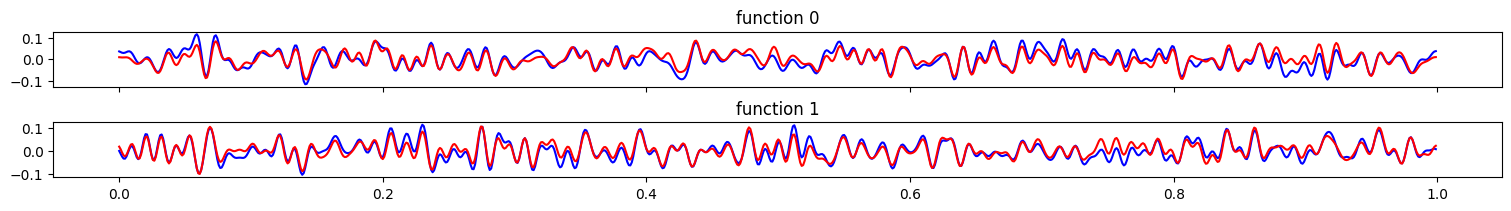

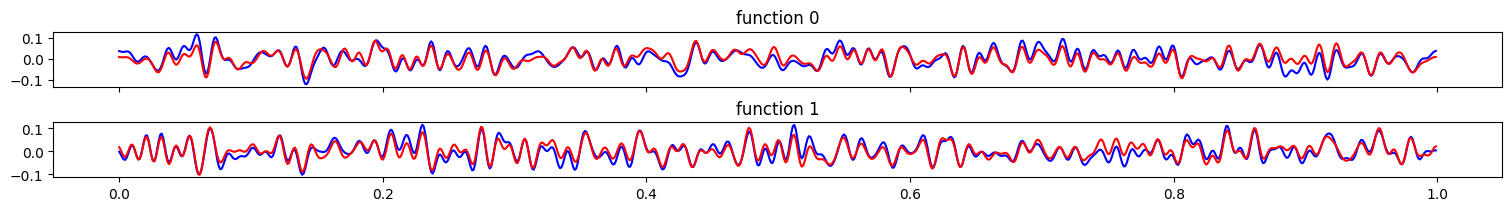

In [76]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_eval = FourierBasis(u_coeff_test)(points_tt).real
# u_coeff_clean_scaled = u_coeff_clean
# u_coeff_clean_scaled = scaler.get_subset_scaler([-1]).transform((u_coeff_clean,))[0][dataset_test.indices]
u_coeff_clean_eval = FourierBasis(u_coeff_clean[dataset_test.indices])(points_tt).real


def plot_funcs(u_pred: torch.Tensor, u: torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 1, figsize=[15, n], constrained_layout=True, sharex=True)
    for i in range(n):
        # axs[i%2, i//2].scatter(points_sampled[:,1], u_sampled[i, :])
        # axs[i%2, i//2].plot(t, u_basis_pred[i].real, color="black")
        # axs[i].plot(t, u_test[i].real, color="blue")
        axs[i].plot(t, u[i].real, color="blue")
        axs[i].plot(t, u_pred[i].real, color="red")
        axs[i].set_title(f"function {i}")

    plt.show()


# plot_funcs(u_pred.real, u_test_eval.real, 2)
# plot_funcs(u_pred, u_coeff_clean_eval, 2)
plot_funcs(u_basis_pred.real, u_test_eval.real, 2)
plot_funcs(u_basis_pred.real, u_coeff_clean_eval, 2)

(400,)
torch.Size([40, 400])


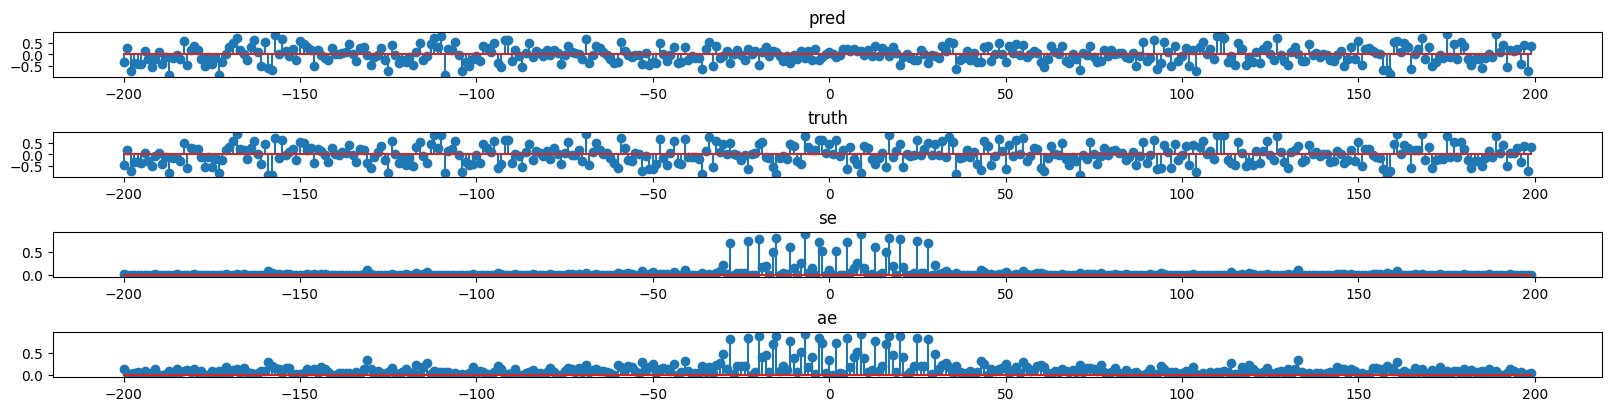

In [77]:
def plot_coeffs(coeff_pred: torch.Tensor, coeff: torch.Tensor, n=0):
    k = FourierBasis.waveNumber(coeff_pred.shape[1]).T[0].numpy() * 1.
    print(k.shape)
    print(coeff_pred.shape)
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(411)
    plt.stem(k,coeff_pred[n])
    plt.title("pred")
    plt.subplot(412)
    plt.stem(k, coeff[n])
    plt.title("truth")
    plt.subplot(413)
    plt.stem(k, mean_squared_error(coeff_pred[n,None], coeff[n,None], squared=True, num_outputs=coeff.shape[1]))
    plt.title("se")
    plt.subplot(414)
    plt.stem(k, coeff_pred[n].sub(coeff[n]).abs())
    plt.title("ae")
    plt.show()


plot_coeffs(to_real_coeff(u_coeff_pred), to_real_coeff(u_coeff_test), 3)


In [13]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test, periods=periods)
u_inv = u_test_basis(points_tt).real
inverse_pred_hf = model_hf.inverse(u_inv, points_tt, epochs=1000, lr=1e-2, loss_fn=mean_squared_error, gain=1e-2).detach()
inverse_pred_hf = model_lf.inverse(u_inv, points_tt, epochs=1000, lr=1e-2, loss_fn=mean_squared_error, gain=1e-2).detach()


In [14]:
f_truth = to_real_coeff(f_coeff_test)
# f_truth = FourierBasis(periods=periods)(points_tt, f_coeff_test, periods=periods,modes=modes).real
# plot_funcs(inverse_pred, f_truth, n=10)
plot_coeffs(inverse_pred, f_truth)

NameError: name 'inverse_pred' is not defined

In [ ]:
preds = inverse_pred.real
targets = f_truth.real
(
    mean_squared_error(preds, targets),
    r2_score(preds, targets),
    mean_absolute_error(preds, targets),
    symmetric_mean_absolute_percentage_error(preds, targets),
    f_truth.shape,
)


(tensor(2.8359),
 tensor(-3.2240),
 tensor(1.2943),
 tensor(1.1594),
 torch.Size([10, 400]))

In [ ]:
# tmp_test = torch.randn((2000, 2000))
# tmp_unscaled = LSSVR(kernel="tri", sigma=1.0)
# tmp_prod = 1 - tmp_unscaled._batched_K(tmp_test, tmp_test)
# display(tmp_prod)
# tmp_sigma = tmp_prod.max()
# tmp_model = LSSVR(kernel="rbf", sigma =tmp_test.var(0).sum()**.5)
# tmp_gram = tmp_model._batched_K(tmp_test,tmp_test)
# display(tmp_gram)
# def is_psd(mat):
#     return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())
# #Test:
# display(is_psd(tmp_gram), is_psd(tmp_prod))
# model.svr.K
# display((tmp_gram == tmp_gram.T).all())
# tmp_eig = torch.linalg.eigvals(tmp_gram).real
# display(tmp_eig[(tmp_eig>=0 )== False], tmp_eig.shape)

In [ ]:
aa = torch.randn((3,4))
aa

tensor([[-0.1999, -1.5842,  0.3177, -0.3765],
        [ 0.1898,  0.4413,  1.0610,  0.3420],
        [ 1.0386, -0.0896,  1.2758,  1.9286]])

In [ ]:
aa[torch.tensor([1,2])] = 0.0

In [ ]:
aa

tensor([[-0.1999, -1.5842,  0.3177, -0.3765],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])